In [1]:
import zstandard
import os
import json
import sys
from datetime import datetime
import logging.handlers


log = logging.getLogger("bot")
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler())


def read_and_decode(reader, chunk_size, max_window_size, previous_chunk=None, bytes_read=0):
	chunk = reader.read(chunk_size)
	bytes_read += chunk_size
	if previous_chunk is not None:
		chunk = previous_chunk + chunk
	try:
		return chunk.decode()
	except UnicodeDecodeError:
		if bytes_read > max_window_size:
			raise UnicodeError(f"Unable to decode frame after reading {bytes_read:,} bytes")
		log.info(f"Decoding error with {bytes_read:,} bytes, reading another chunk")
		return read_and_decode(reader, chunk_size, max_window_size, chunk, bytes_read)


def read_lines_zst(file_name):
	with open(file_name, 'rb') as file_handle:
		buffer = ''
		reader = zstandard.ZstdDecompressor(max_window_size=2**31).stream_reader(file_handle)
		while True:
			chunk = read_and_decode(reader, 2**27, (2**29) * 2)

			if not chunk:
				break
			lines = (buffer + chunk).split("\n")

			for line in lines[:-1]:
				yield line, file_handle.tell()

			buffer = lines[-1]

		reader.close()

In [2]:
file_path = "data/mbti_submissions.zst"
file_size = os.stat(file_path).st_size
file_lines = 0
file_bytes_processed = 0
created = None
field = "subreddit"
value = "mbti"
bad_lines = 0
objs = []
# try:
for line, file_bytes_processed in read_lines_zst(file_path):
    try:
        obj = json.loads(line)
        objs.append(obj)
        created = datetime.fromtimestamp(int(obj['created_utc']))
        temp = obj[field] == value
    except (KeyError, json.JSONDecodeError) as err:
        bad_lines += 1
    file_lines += 1
    if file_lines % 100000 == 0:
        log.info(f"{created.strftime('%Y-%m-%d %H:%M:%S')} : {file_lines:,} : {bad_lines:,} : {file_bytes_processed:,}:{(file_bytes_processed / file_size) * 100:.0f}%")

# except Exception as err:
# 	log.info(err)

log.info(f"Complete : {file_lines:,} : {bad_lines:,}")

2021-04-23 02:00:41 : 100,000 : 0 : 30,016,175:61%
Complete : 192,593 : 0


In [3]:
import pandas as pd
df = pd.DataFrame(objs)

In [4]:
df.keys()

Index(['archived', 'author', 'author_flair_background_color',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_text_color', 'author_flair_type', 'brand_safe',
       'can_gild',
       ...
       'poll_data', 'upvote_ratio', 'is_created_from_ads_ui', 'retrieved_utc',
       'top_awarded_type', 'url_overridden_by_dest', 'gallery_data',
       'is_gallery', 'call_to_action', 'collections'],
      dtype='object', length=128)

- "author"
- "author_flair_css_class": label
- "title": titolo del post
- "selftext": testo del post
- "is_self": indicates whether the post is a text post (i.e. not linking outside) or not — I used this to filter out any image or url posts.
- 

In [5]:
cols = [df['author'], df['author_flair_css_class'], df['title'], df['selftext'], df['is_self'], df['id']]
df_small = pd.DataFrame(cols)
df=df_small.T
df

,author,author_flair_css_class,title,selftext,is_self,id
0,rntksi,infp,Tips for personal growth tailored to each type...,,False,etvvt
1,rntksi,infp,This subreddit is brand new! (more inside),And I'm going to work on it for a bit before s...,True,etvwm
2,0vertime,,Is this subreddit alive?,"I randomly typed /r/mbti to see if it existed,...",True,g1d7b
3,rntksi,,What's your MBTI type?,"As the title says, you can reply here with you...",True,g1rf3
4,0vertime,,"An intro to Keirsey sorting, unbiased type des...",I've found that the Keirsey language REALLY im...,True,g3tg3
...,...,...,...,...,...,...
192588,[deleted],None,State your type and the type(s) you tend to be...,[deleted],True,1006j8c
192589,High__IQ__ENTJ,entj,Do any other ENTJs hate having to deal with in...,I am wondering if this is an entj-specific thi...,True,1006jo0
192590,chaos-seeker320,estj,sooo....do intps actually look like this?,,False,1006kz8
192591,Ash__Williams,None,"INTP here. NO AMA. Drink some water, touch som...",Happy Holidays.,True,1006lmd


In [6]:
# drops deleted account
i = df[((df.author == '[deleted]'))].index
df = df.drop(i)
print(len(i))
print(df['author'].value_counts())

# keeps users with mtbi flag
mbti = ['intj', 'intp', 'entj', 'entp', 'infj', 'infp', 'enfj', 'enfp', 'istj', 'isfj', 'estj', 'esfj', 'istp', 
        'isfp', 'estp', 'esfp']
df = df[df['author_flair_css_class'].isin(mbti)]
df

72537
Hydra-Sagaria           866
Twili95                 560
virekkartgod            485
Wondering_Fairy         454
RTX2080Ti0              356
                       ... 
Equiin                    1
help-help-help-           1
just_a_normal_persom      1
albumparty                1
High__IQ__ENTJ            1
Name: author, Length: 42474, dtype: int64


,author,author_flair_css_class,title,selftext,is_self,id
0,rntksi,infp,Tips for personal growth tailored to each type...,,False,etvvt
1,rntksi,infp,This subreddit is brand new! (more inside),And I'm going to work on it for a bit before s...,True,etvwm
6910,Flux_n_Uck,estp,Covert Narcissism and the INFJ,"If ESTPs are Overt Narcissists, does that mean...",True,4m1eit
6922,petrakay,estj,Successful relationships for low-stack Feeling...,"So, the thread yesterday about attraction betw...",True,4m3v04
6928,cypranius,entp,Fun with Intuitive Bias (Credit /u/acornzyall),This is one of my favorite posts from the olde...,True,4m8287
...,...,...,...,...,...,...
192584,ReaperofLightning872,intj,I am an INTJ. Ask me anything. Or whatever. (A...,,False,1006329
192585,Panetella,intp,All my life I’ve been typed as a INTP and now ...,,False,1006762
192586,Kwerz_,intj,Well I'm not suprised.,,False,1006cr3
192589,High__IQ__ENTJ,entj,Do any other ENTJs hate having to deal with in...,I am wondering if this is an entj-specific thi...,True,1006jo0


intp    9527
infp    8399
entp    8066
intj    6431
infj    6060
enfp    4619
entj    3166
istp    3078
estp    2302
isfp    1960
isfj    1720
estj    1709
enfj    1428
istj    1200
esfp     789
esfj     357
Name: author_flair_css_class, dtype: int64


<AxesSubplot:>

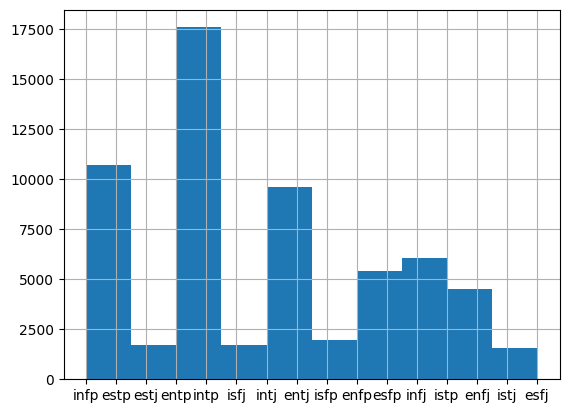

In [7]:
print(df['author_flair_css_class'].value_counts())
df['author_flair_css_class'].hist()

In [8]:
path = 'data/small_users.csv'
df.to_csv(path, index=False)

In [9]:
new = pd.read_csv(path, index_col=False)
new

,author,author_flair_css_class,title,selftext,is_self,id
0,rntksi,infp,Tips for personal growth tailored to each type...,NaN,False,etvvt
1,rntksi,infp,This subreddit is brand new! (more inside),And I'm going to work on it for a bit before s...,True,etvwm
2,Flux_n_Uck,estp,Covert Narcissism and the INFJ,"If ESTPs are Overt Narcissists, does that mean...",True,4m1eit
3,petrakay,estj,Successful relationships for low-stack Feeling...,"So, the thread yesterday about attraction betw...",True,4m3v04
4,cypranius,entp,Fun with Intuitive Bias (Credit /u/acornzyall),This is one of my favorite posts from the olde...,True,4m8287
...,...,...,...,...,...,...
60806,ReaperofLightning872,intj,I am an INTJ. Ask me anything. Or whatever. (A...,NaN,False,1006329
60807,Panetella,intp,All my life I’ve been typed as a INTP and now ...,NaN,False,1006762
60808,Kwerz_,intj,Well I'm not suprised.,NaN,False,1006cr3
60809,High__IQ__ENTJ,entj,Do any other ENTJs hate having to deal with in...,I am wondering if this is an entj-specific thi...,True,1006jo0
